# Manipulation of CMIP6 model data using Pangeo catalog

## Import python packages

In [2]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

## Open CMIP6 online catalog

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


## Search corresponding data 

In [4]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,Amon,o3,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20191108


In [5]:
#cat = col.search( experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1'])
#cat.df


## Reading file from bucket

In [6]:
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022')

['escience2022/Ada',
 'escience2022/Antoine',
 'escience2022/Dominic',
 'escience2022/ESA_SMOS_sss',
 'escience2022/Remy',
 'escience2022/Sara',
 'escience2022/Zhihong']

In [7]:
s3path = "s3://escience2022/Zhihong/o3_AERmon_GISS-E2-1-G_historical_r1i1p3f1_gn_185001-190012.nc"

In [8]:
do = xr.open_dataset(s3.open(s3path))
do

<xarray.Dataset>
Dimensions:    (time: 612, bnds: 2, lev: 40, lat: 90, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lev        (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.23 0.21 0.19 0.17
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lev_bnds   (lev, bnds) float64 ...
    p0         float64 ...
    a          (lev) float64 ...
    b          (lev) float64 ...
    ps         (time, lat, lon) float32 ...
    a_bnds     (lev, bnds) float64 ...
    b_bnds     (lev, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    o3         (time, lev, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                Kenneth Lo (cdkkl@giss.nasa.gov)
    ...                     ...
    title:                  GISS-E2-1-G output prepared for CMIP6
    tracking_id:            hdl:21.14100/0597de11-e334-4b70-9ff6-435e00c6dca2
    variable_id:            o3
    variant_label:          r1i1p3f1
    license:                CMIP6 model data produced by NASA Goddard Institu...
    cmor_version:           3.3.2

## Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [9]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
list(dset_dict.keys())

['CMIP.NCC.NorESM2-LM.historical.Amon.gn']

## Open dataset

- Use `xarray` python package to analyze netCDF dataset
- `open_dataset` allows to get all the metadata without loading data into memory. 
- with `xarray`, we only load into memory what is needed.

In [11]:
dset = dset_dict['CMIP.NCC.NorESM2-LM.historical.Amon.gn']
dset

<xarray.Dataset>
Dimensions:    (lat: 96, bnds: 2, lon: 144, member_id: 1, time: 780, plev: 19)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    o3         (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 173, 19, 96, 144), meta=np.ndarray>
Attributes: (12/54)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    variable_id:               o3
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/24f26c2d-9e8f-40b1-af07-79c8c2f91...
    version_id:                v20191108
    intake_esm_varname:        ['o3']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.Amon.gn

### Get metadata corresponding to near-surface air temperature (tas)

In [12]:
print(do['o3'].lev)

<xarray.DataArray 'lev' (lev: 40)>
array([0.95, 0.93, 0.91, 0.89, 0.87, 0.85, 0.83, 0.81, 0.79, 0.77, 0.75, 0.73,
       0.71, 0.69, 0.67, 0.65, 0.63, 0.61, 0.59, 0.57, 0.55, 0.53, 0.51, 0.49,
       0.47, 0.45, 0.43, 0.41, 0.39, 0.37, 0.35, 0.33, 0.31, 0.29, 0.27, 0.25,
       0.23, 0.21, 0.19, 0.17])
Coordinates:
  * lev      (lev) float64 0.95 0.93 0.91 0.89 0.87 ... 0.25 0.23 0.21 0.19 0.17
Attributes:
    bounds:         lev_bnds
    units:          1
    axis:           Z
    positive:       down
    long_name:      hybrid sigma pressure coordinate
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula:        p = a*p0 + b*ps
    formula_terms:  p0: p0 a: a b: b ps: ps


In [36]:
do.time.values;

### Select time

- Select a specific time

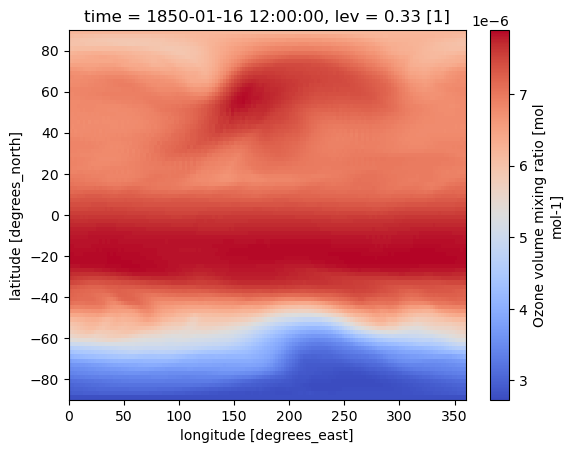

In [14]:
do['o3'].sel(time=cftime.DatetimeNoLeap(1850, 1, 16, 12,0,0,0)).isel(lev=31).plot(cmap = 'coolwarm')

- select the nearest time. Here from 1st April 1950

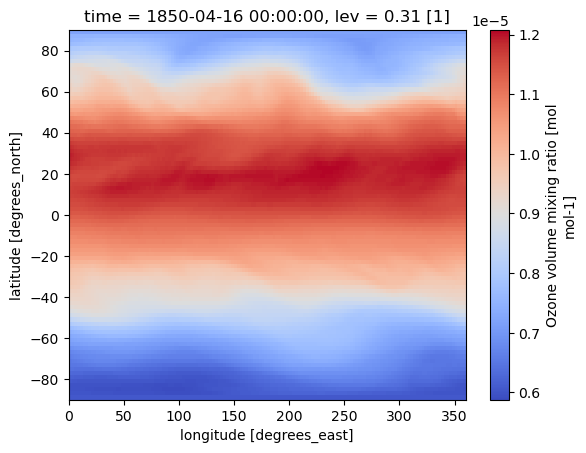

In [15]:
do['o3'].sel(time=cftime.DatetimeNoLeap(1850, 4, 1), method='nearest').isel(lev=32).plot(x = 'lon',cmap='coolwarm')

### Find what level the ozone layer is

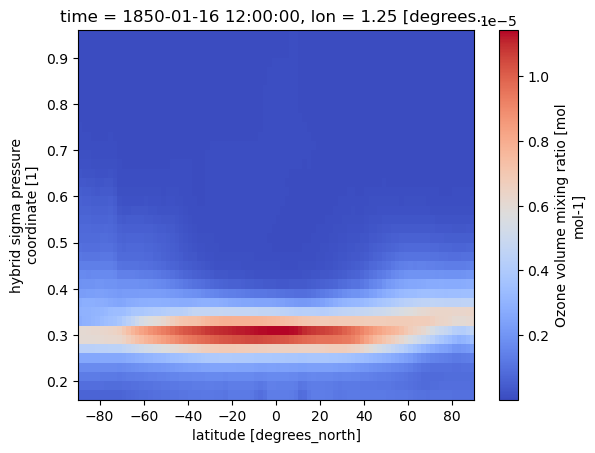

In [16]:
do['o3'].sel(time=cftime.DatetimeNoLeap(1850, 1, 16, 12,0,0,0)).isel(lon=0).plot(cmap = 'coolwarm')

# Customize plot

### Set the size of the figure and add coastlines

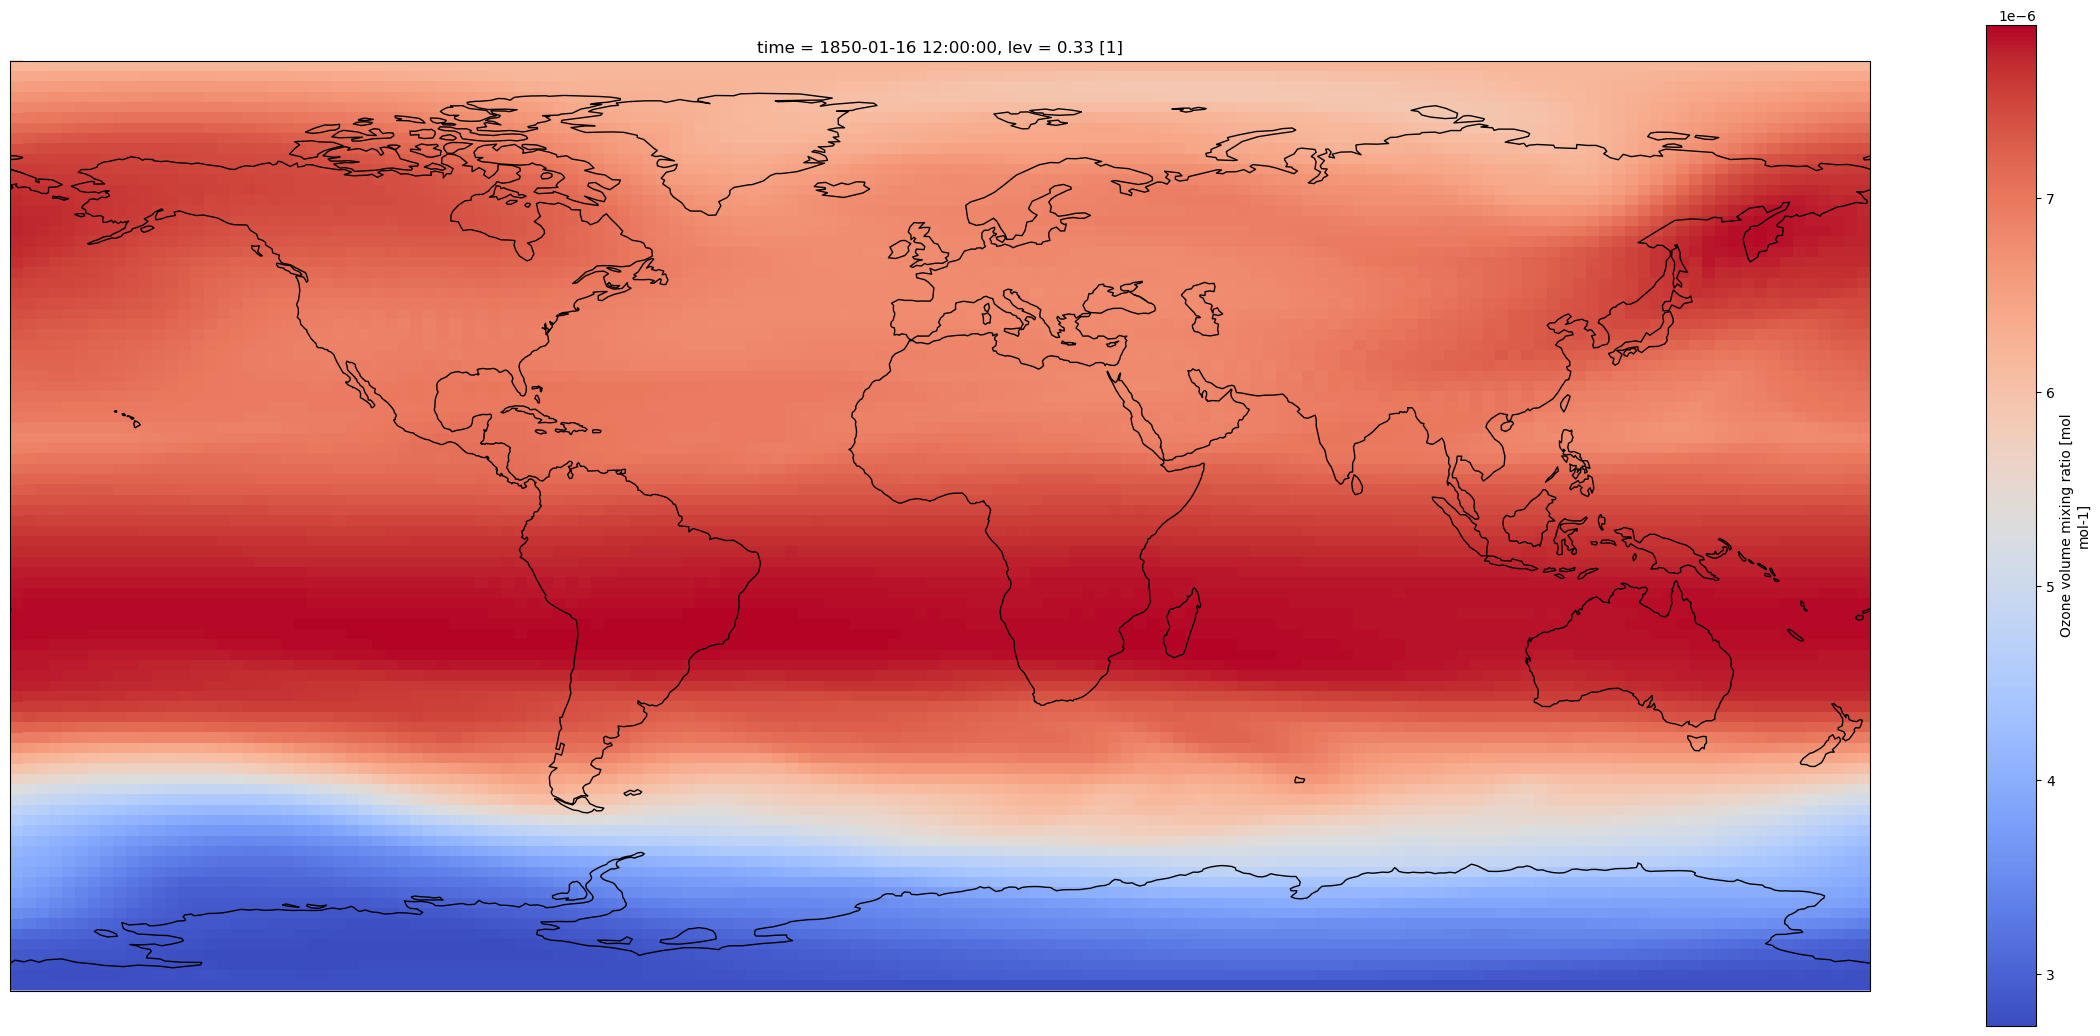

In [17]:
fig = plt.figure(1, figsize=[30,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
do['o3'].isel(time=0).squeeze().isel(lev=31).plot.pcolormesh(ax=ax, cmap='coolwarm')

### Change plotting projection

Text(0.5, 1.0, 'July 1850')

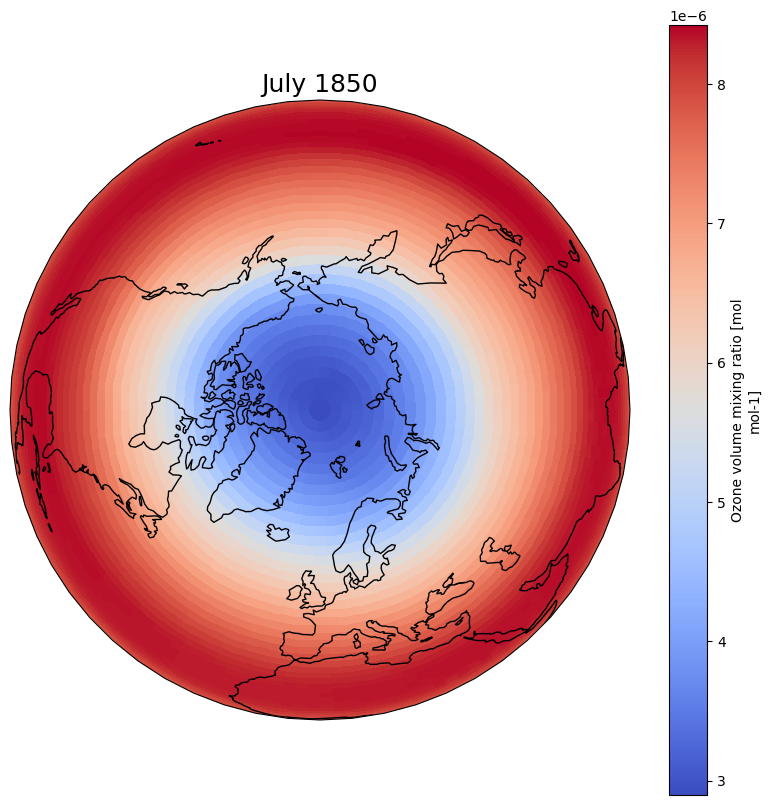

In [18]:
fig = plt.figure(1, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
do['o3'].isel(time=6).squeeze().isel(lev=31).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title(do.time.values[6].strftime("%B %Y"), fontsize=18)

### Choose the extent of values
- Fix your minimum and maximum values in your plot and
- Use extend so values below the minimum and max

Text(0.5, 1.0, 'July 1850')

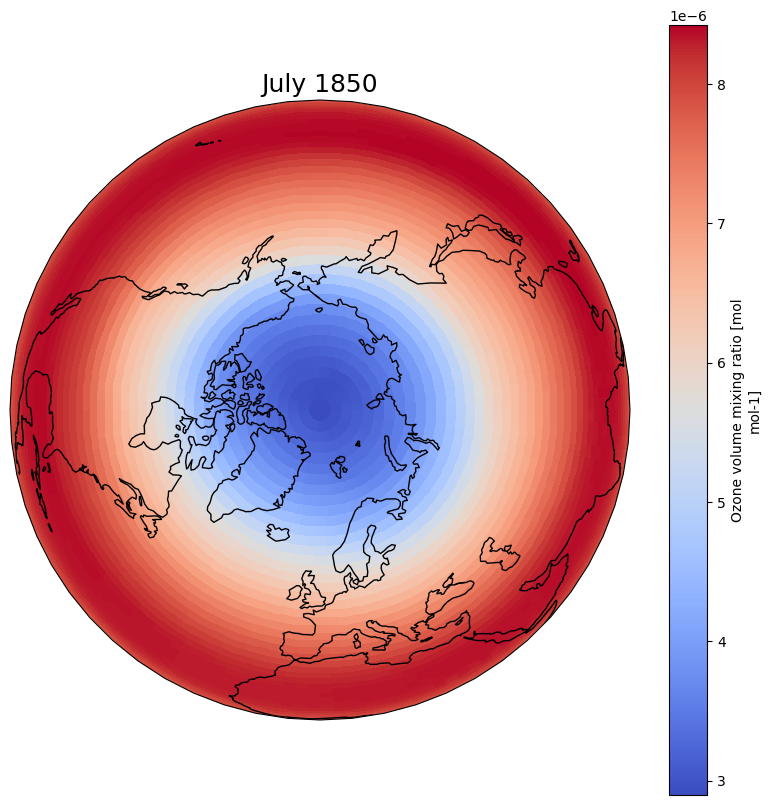

In [19]:
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# Fix extent
minval = do['o3'].min()
maxval = do['o3'].max()

# pass extent with vmin and vmax parameters
do['o3'].isel(time=6).squeeze().isel(lev=31).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title(do.time.values[6].strftime("%B %Y"), fontsize=18)

# Multiplots
### Faceting

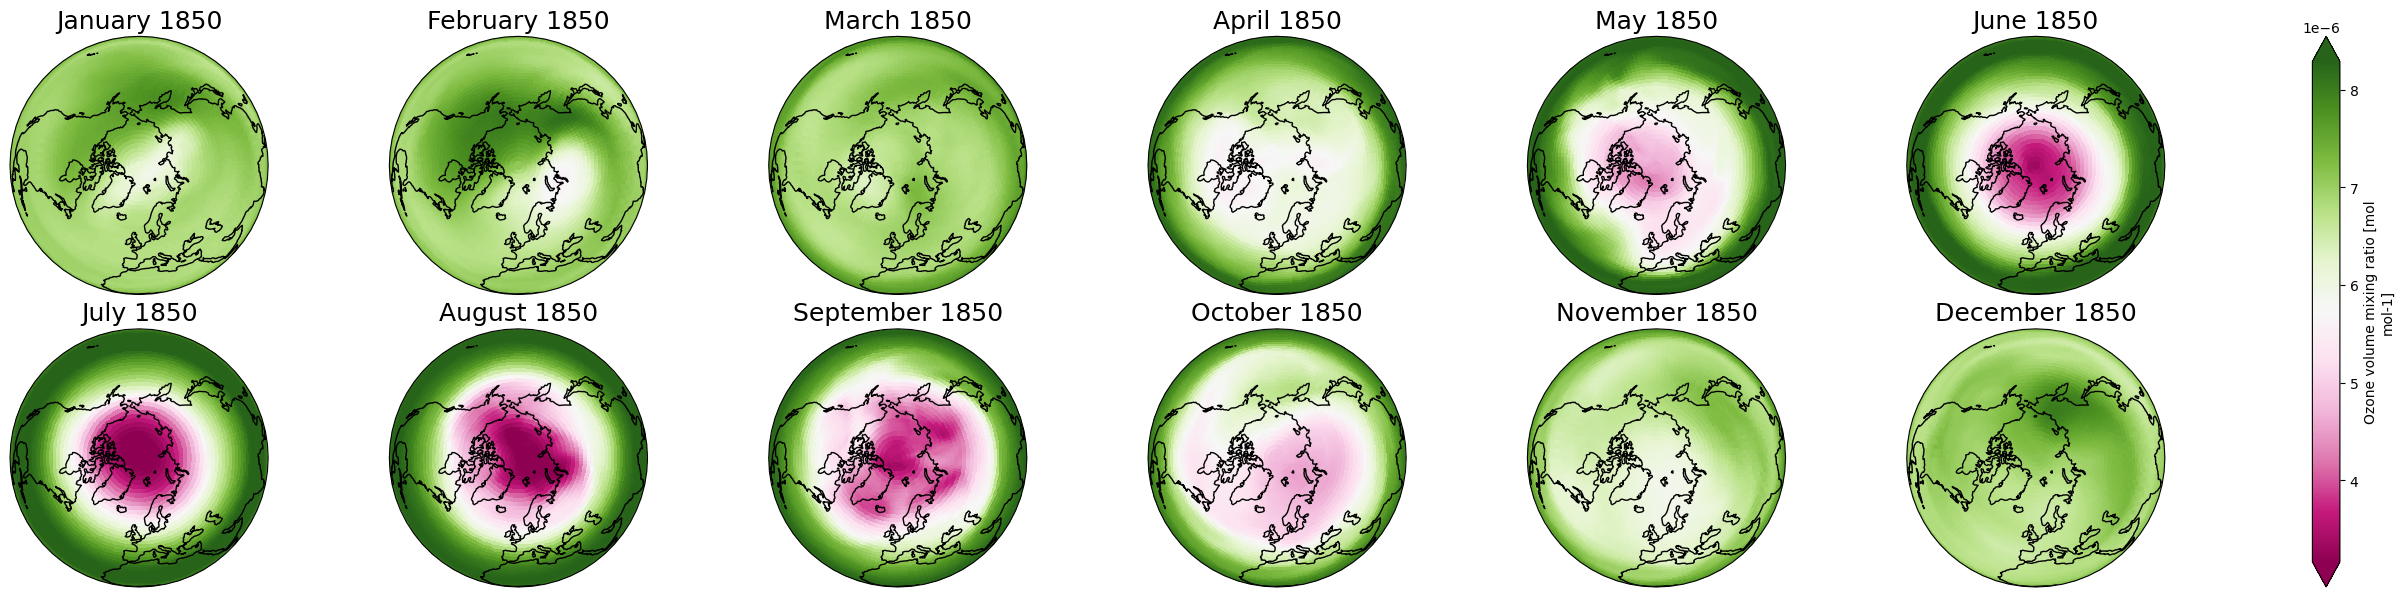

In [20]:
proj_plot = ccrs.Orthographic(0, 90)

p = do['o3'].sel(time = do.time.dt.year.isin([1850, 2014])).squeeze().isel(lev=31).plot(x='lon', y='lat', 
                                                                 transform=ccrs.PlateCarree(),
                                                                 aspect=do.dims["lon"] / do.dims["lat"],  # for a sensible figsize
                                                                 subplot_kws={"projection": proj_plot},
                                                                 col='time', col_wrap=6, robust=True, cmap='PiYG')
# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat,  do.time.sel(time = do.time.dt.year.isin([1850, 2014])).values):
    ax.coastlines()
    ax.set_title(i.strftime("%B %Y"), fontsize=18)

### Combine plots with different projections

Text(0, 0.5, 'K')

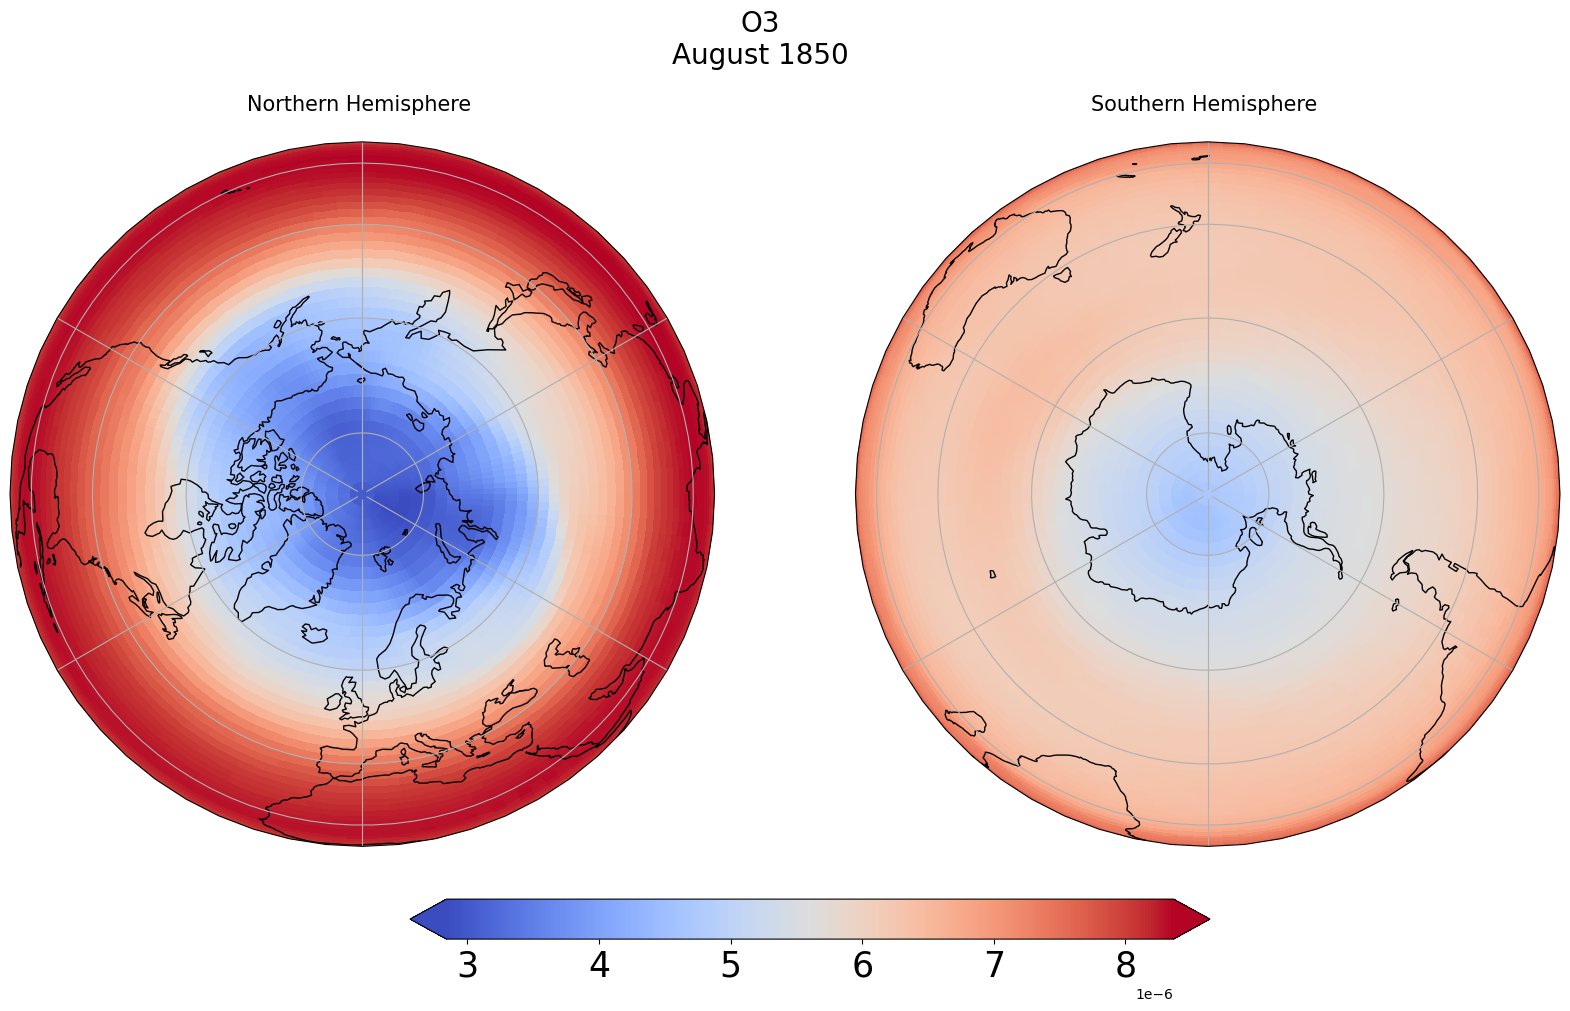

In [21]:
fig = plt.figure(1, figsize=[20,10])

# Fix extent
minval = do['o3'].min()
maxval = do['o3'].max()

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

tsel = 7
for ax,t in zip([ax1, ax2], ["Northern", "Southern"]):
    map = do['o3'].isel(time=tsel).isel(lev=31).squeeze().plot(ax=ax, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)
    ax.set_title(t + " Hemisphere \n" , fontsize=15)
    ax.coastlines()
    ax.gridlines()

# Title for both plots
fig.suptitle('O3\n' + do.time.values[tsel].strftime("%B %Y"), fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel('K', fontsize=25)

### Time series


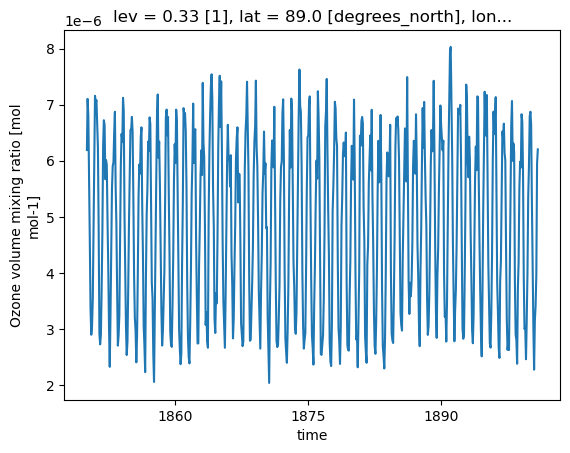

In [40]:
do['o3'].sel(lon=1, lat=90, method='nearest').isel(lev=31).plot(x='time')

ValueError: the first argument to .sel must be a dictionary